In [70]:
import pandas as pd
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from keras.optimizers import Adam
from keras.models import load_model
import random
import os
import matplotlib.pyplot as plt
from keras.applications import VGG16
import shutil
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import numpy as np
import pylab
import tensorflow as tf 

In [3]:
# Get list of artist
train_dir = 'images/images'
test_dir = 'test_images'
artists = pd.read_csv('artists.csv')
print(artists.shape)
# Check that artists have an image folder
artist_dirs = os.listdir(train_dir)
artists['dir'] = artists['name'].str.split(' ').str.join('_')
for name in artists['dir']:
    if name not in artist_dirs:
        print('Cannot find ',name)

(50, 8)


In [4]:
# Get number of paintings of each artist
artists.sort_values(by='paintings',inplace=True,ascending=False)
top_artists = artists[artists['paintings'] > 100]
print(top_artists.loc[:,['name','paintings']])


name  paintings
8        Vincent van Gogh        877
30            Edgar Degas        702
13          Pablo Picasso        439
15  Pierre-Auguste Renoir        336
19         Albrecht Durer        328
46           Paul Gauguin        311
16         Francisco Goya        291
31              Rembrandt        262
20          Alfred Sisley        259
32                 Titian        255
22           Marc Chagall        239
4           Rene Magritte        194
0       Amedeo Modigliani        193
42              Paul Klee        188
28          Henri Matisse        186
45            Andy Warhol        181
12         Mikhail Vrubel        171
24      Sandro Botticelli        164
26      Leonardo da Vinci        143
14      Peter Paul Rubens        141
5           Salvador Dali        139
10       Hieronymus Bosch        137
21         Pieter Bruegel        134
27        Diego Velazquez        128
11       Kazimir Malevich        126
17            Frida Kahlo        120
23      Giotto di Bond

In [5]:
# 6 artists have > 300 paintings. We narrow the problem to classifying paintings by these artists only
top_artists = artists[artists['paintings'] > 300].reset_index()
top_artists['class_weight'] = top_artists.paintings.sum() / (top_artists.shape[0] * top_artists.paintings)
print(top_artists.loc[:,['name','paintings','class_weight']])
print('Total number of paintings: ',top_artists['paintings'].sum())
class_weights = top_artists['class_weight'].to_dict()
print(class_weights)

name  paintings  class_weight
0       Vincent van Gogh        877      0.568795
1            Edgar Degas        702      0.710589
2          Pablo Picasso        439      1.136295
3  Pierre-Auguste Renoir        336      1.484623
4         Albrecht Durer        328      1.520833
5           Paul Gauguin        311      1.603966
Total number of paintings:  2993
{0: 0.5687951349296845, 1: 0.7105887939221273, 2: 1.136294608959757, 3: 1.4846230158730158, 4: 1.5208333333333333, 5: 1.6039657020364415}


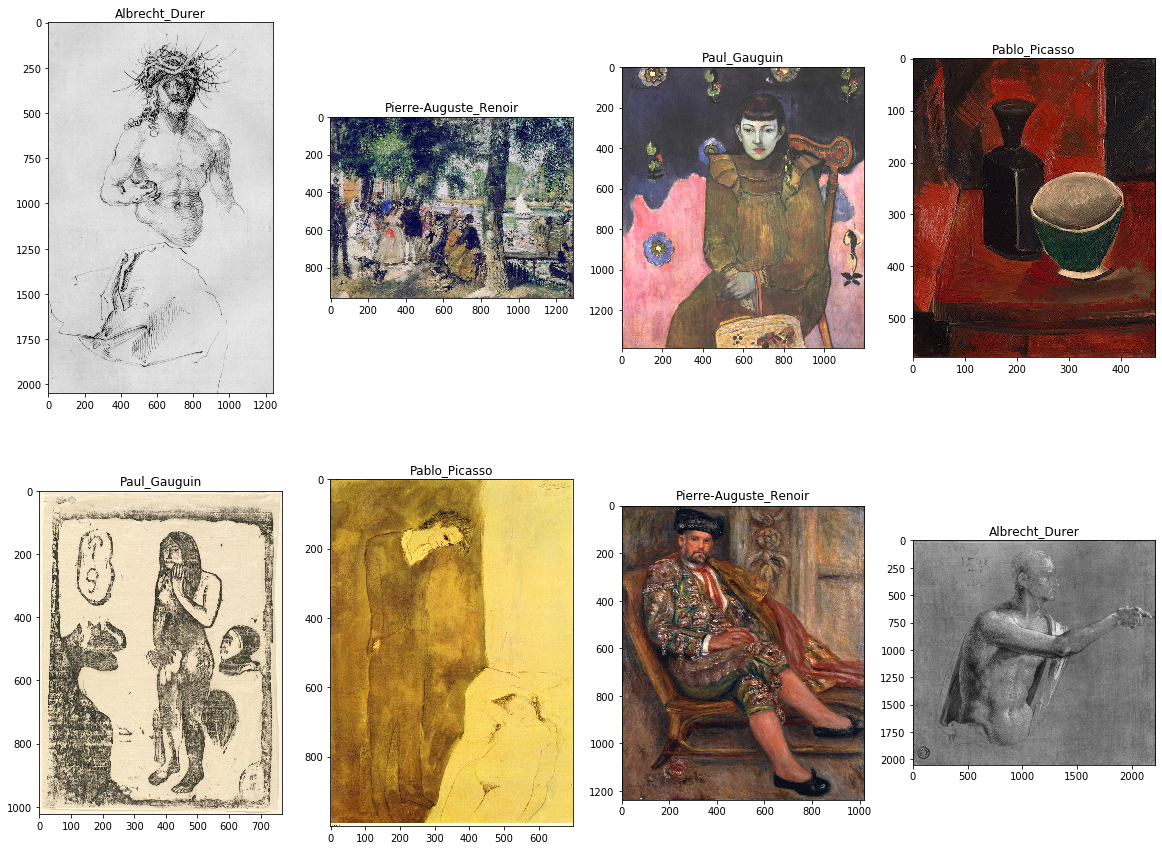

In [6]:
# Show a few random paintings
fig_size = (2,4)
fig, axes = plt.subplots(fig_size[0],fig_size[1],figsize=(20,15))
for row in axes:
    for axe in row:
        random_name = random.choice(top_artists['dir'].to_list())
        random_image = random.choice(os.listdir(os.path.join(train_dir,random_name)))
        random_image_file = os.path.join(train_dir,random_name,random_image)
        random_image_file = plt.imread(random_image_file)
        axe.imshow(random_image_file)
        axe.set_title(random_name)

In [7]:
# Randomly remove 5 paintings by each artist from training data to use as a test set
'''
for name in top_artists['dir']:
    for i in range(0,5):
        random_image = random.choice(os.listdir(os.path.join(train_dir, name)))
        an_image = os.path.join(train_dir, name, random_image)
        artist_test_folder = test_dir+'/'+name
        if not os.path.exists(artist_test_folder):
            os.mkdir(artist_test_folder)
            dest_dir = artist_test_folder + '/' + random_image
            shutil.move(an_image, dest_dir)
'''


"\nfor name in top_artists['dir']:\n    for i in range(0,5):\n        random_image = random.choice(os.listdir(os.path.join(train_dir, name)))\n        an_image = os.path.join(train_dir, name, random_image)\n        artist_test_folder = test_dir+'/'+name\n        if not os.path.exists(artist_test_folder):\n            os.mkdir(artist_test_folder)\n            dest_dir = artist_test_folder + '/' + random_image\n            shutil.move(an_image, dest_dir)\n"

In [16]:
# Create training data generator with augmentation
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = top_artists.shape[0]
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory='images/images',
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=top_artists['dir'].tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory='images/images',
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=top_artists['dir'].tolist()
                                                    )
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

Found 2373 images belonging to 6 classes.
Found 590 images belonging to 6 classes.


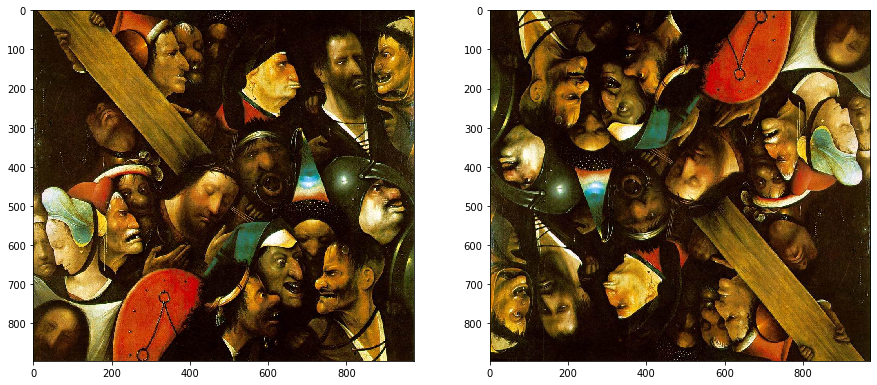

In [9]:
# Show an image and its augmented version
an_artist = artists.loc[10,'dir']
random_image = random.choice(os.listdir(os.path.join(train_dir, an_artist)))
an_image = os.path.join(train_dir, an_artist, random_image)
image_file = plt.imread(an_image)
fig, axes = plt.subplots(1, 2, figsize=(15,10))
axes[0].imshow(image_file)
aug_image = train_datagen.random_transform(image_file)
axes[1].imshow(aug_image)

In [11]:
# Option 2: Use a retrained model (RESNET50), and fine tune on the dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
#model = load_model('deep_art_new.h5')
for layer in base_model.layers:
    layer.trainable = True
X = base_model.output
X = Flatten()(X)
X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)
model = Model(inputs=base_model.input, outputs=output)
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])
n_epoch = 5

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
# Option 1: Build own model from sratch
# Build a model
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='sigmoid'))
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])
model.summary()

In [ ]:
# Option 1: Build own model from sratch
#model = load_model('deep_art_new.h5')
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=valid_generator,
      validation_steps=50,
      class_weight=class_weights)
model.save('deep_art_new.h5')

In [ ]:
# Option 2: Use a retrained model (RESNET50), and fine tune on the dataset
#model = load_model('resnet_full.h5')
n_epoch = 3
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )
model.save('resnet_full.h5')

In [17]:
# Option 2: Use a retrained model (RESNET50), and fine tune on the dataset
from tensorflow.keras.models import load_model #Somehow import load_model from keras does not work for pre-trained model. Re-import as a workaround
#model = load_model('resnet_full.h5')
#model = load_model('resnet_retrain.h5')
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[:50]:
    layer.trainable = True
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])
n_epoch = 1
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )
model.save('resnet_retrain.h5')

148/148 [==============================] - 1967s 13s/step - loss: 0.3694 - accuracy: 0.9431 - val_loss: 0.5548 - val_accuracy: 0.8819


In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

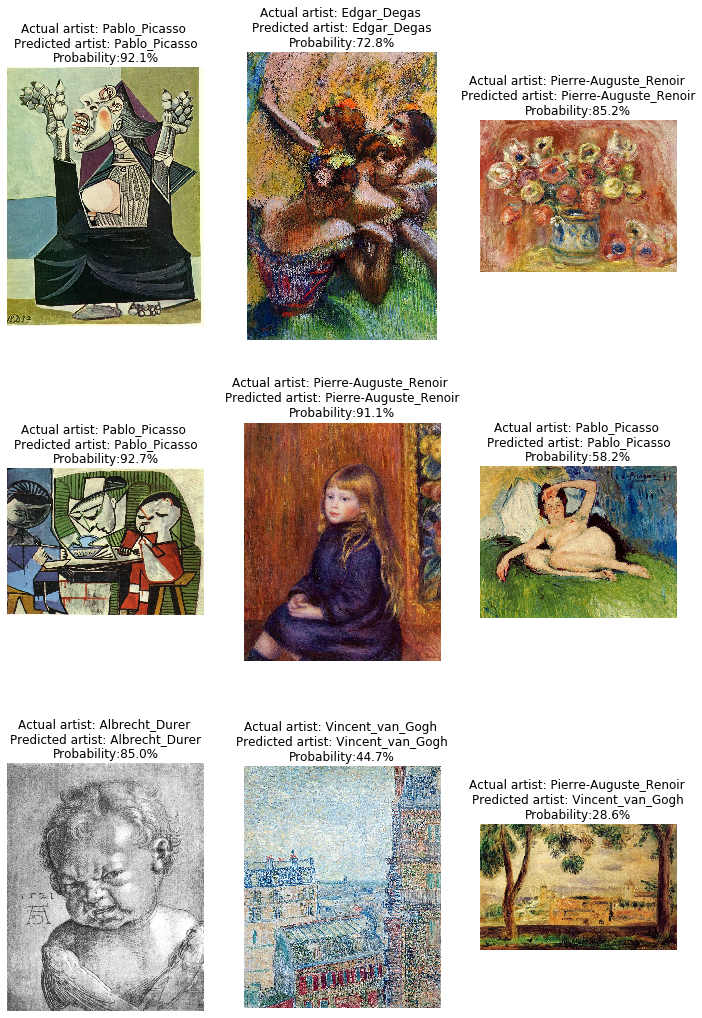

In [130]:
# Make prediction on images the model have not seen before
from tensorflow.keras.models import load_model
#model = load_model('resnet_retrain.h5')
import numpy as np

# Get the index of artists
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

fig_size = (3,3)
fig, axes = plt.subplots(fig_size[0],fig_size[1],figsize=(12,18))
for row in axes:
    for axe in row:
        random_name = random.choice(top_artists['dir'].to_list())
        random_image = random.choice(os.listdir(os.path.join(test_dir,random_name)))
        random_image_file = os.path.join(test_dir,random_name,random_image)
        test_image = image.load_img(random_image_file,target_size=(224,224))
        test_image = image.img_to_array(test_image)
        test_image /=255.
        test_image = np.expand_dims(test_image,axis=0)
        prediction = model.predict(test_image)
        prediction_probability = np.amax(prediction)
        prediction_idx = np.argmax(prediction)

        title = "Actual artist: {} \nPredicted artist: {}\nProbability:{:.1f}%".format(random_name,labels[prediction_idx],prediction_probability*100)
        axe.imshow(plt.imread(random_image_file))
        axe.set_title(title)
        axe.axis('off')

In [ ]:
# Visualising the output at the layers
model = load_model('deep_art.h5')
model.summary()

In [118]:
image_name = 'Rembrandt_120.jpg'
an_image = os.path.join(test_dir,'Rembrandt',image_name)
an_image_path = an_image
an_image = image.load_img(an_image,target_size=(224,224))
an_image = image.img_to_array(an_image)
an_image /=255.
an_image = np.expand_dims(an_image,axis=0)
an_image.shape

(1, 224, 224, 3)

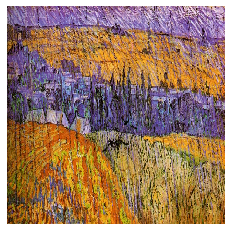

In [106]:
#show the image
plt.imshow(an_image[0])
plt.axis('off')
plt.show()

(1, 112, 112, 64)


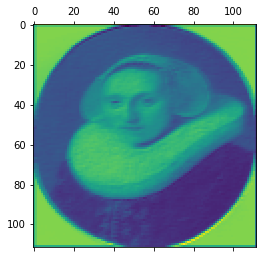

In [119]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(an_image)
first_layer_activation = activations[3]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

In [64]:
model.summary()
print(len(activations))

[0]           
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_0_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_0_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_add (Add)          (None, 14, 14, 1024) 0           conv4_block1_0_bn[0][0]          
                                                                 conv4_block1_3_bn[0][0]          
______________________________________________________________________________________________

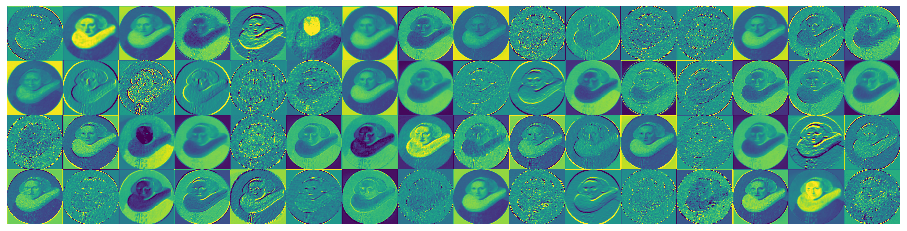

In [94]:
# Visualising all channels in all layers
%matplotlib inline
images_per_row = 16
for layer_activation in [activations[2]]:
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
             channel_image = layer_activation[0,:,:,col * images_per_row + row]
             channel_image -= channel_image.mean()
             channel_image /= channel_image.std()
             channel_image *= 64
             channel_image += 128
             channel_image = np.clip(channel_image, 0, 255).astype('uint8')
             display_grid[col * size : (col + 1) * size,row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


In [99]:
# Visualising heatmap of class activation
preds = model.predict(an_image)
for i in  range(preds.shape[1]):
    prob = preds[0][i]
    print('Probability for {} is {:.2f}%'.format(labels[i],prob*100) )

Probability for Vincent_van_Gogh is 63.44%
Probability for Edgar_Degas is 4.57%
Probability for Pablo_Picasso is 4.82%
Probability for Pierre-Auguste_Renoir is 4.93%
Probability for Albrecht_Durer is 9.25%
Probability for Paul_Gauguin is 12.99%


In [101]:
from keras import backend as K
max_idx = np.argmax(preds[0])
print(max_idx)
picasso_output = model.output[:,max_idx]
last_conv_layer = model.get_layer('conv5_block3_out')
grads = K.gradients(picasso_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([an_image])
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

0


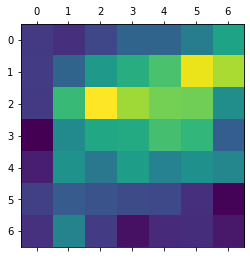

In [102]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [103]:
import cv2
img = cv2.imread(an_image_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.7 + img
cv2.imwrite('overlay_heatmap.jpg', superimposed_img)

True